# Codigo ejemplo de Turbinas Eólicas

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5380 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 8192 |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 1967      |
|    iterations           | 2         |
|    time_elapsed         | 8         |
|    total_timesteps      | 16384     |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -7.09     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 3.58e+15  |
|    n_updates            | 10        |
|    policy_gradient_loss | -1.61e-07 |
|    std                  | 1         |
|    value_loss           | 7.09e+15  |
---------------------------------------
-------------

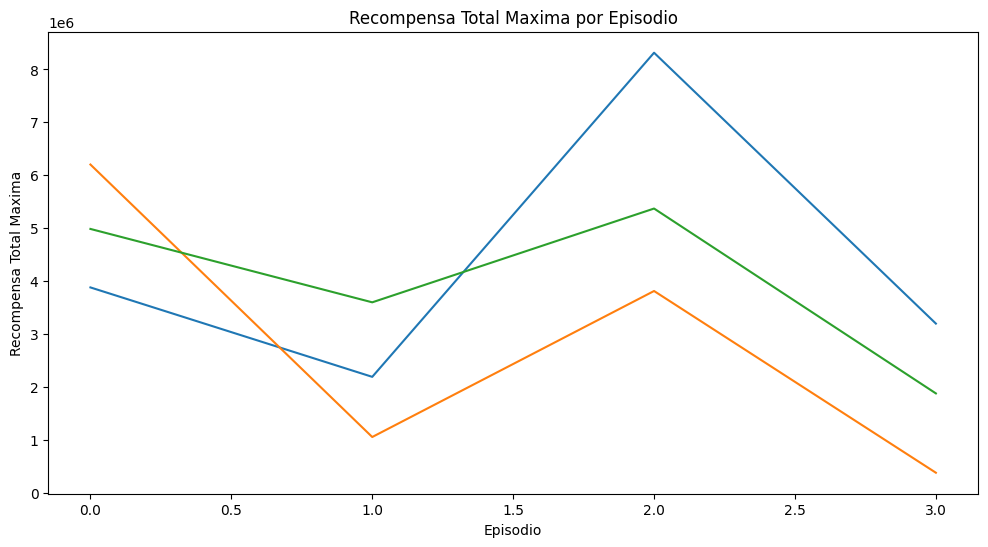

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

# Uso DQN
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed


from custom_env.turbinas_env import TurbinasEnv



def make_env(env_id: str, rank: int, seed: int):
    def _init():
        try:
            
            env = gym.make(env_id, render_mode="human")
            env.reset(seed=seed + rank)
            return env
        except Exception as e:
            # Esto imprimirá cualquier error que ocurra dentro del entorno
            print(f"Error al inicializar el entorno: {e}")
            raise e
    set_random_seed(seed)
    return _init


if __name__ == "__main__":
    env_id = 'TurbinasEnv-v0'  # Asegúrate de que este ID coincida con el que registraste

    num_cpu = 4  # Number of processes to use
    # Create the vectorized environment

    seed = np.random.randint(0, 10)


    vec_env = DummyVecEnv([make_env(env_id, i, seed) for i in range(num_cpu)])


    # Stable Baselines provides you with make_vec_env() helper
    # which does exactly the previous steps for you.
    # You can choose between `DummyVecEnv` (usually faster) and `SubprocVecEnv`
    # env = make_vec_env(env_id, n_envs=num_cpu, seed=0, vec_env_cls=SubprocVecEnv)

    model = PPO("MultiInputPolicy", vec_env, verbose=1, n_steps=2048)
    model.learn(total_timesteps=25_000)

    # Initialize the rewards list for each environment
    episode_rewards = [[] for _ in range(num_cpu)]
    episode_reward = [0 for _ in range(num_cpu)]

    obs = vec_env.reset()
    for _ in range(1000):  # Increase the range if necessary to cover entire episodes
        action, _states = model.predict(obs)
        obs, rewards, dones, info = vec_env.step(action)

        print(f"Rewards: {rewards}, Dones: {dones}")  # Debug: Imprime las recompensas y dones
        
        max=0

        for i in range(num_cpu):
            if max<rewards[i]:
                episode_reward[i]=rewards[i]
                max=episode_reward[i]
            #episode_reward[i] += rewards[i]

            if dones[i]:
                episode_rewards[i].append(episode_reward[i])
                max=0
                episode_reward[i] = 0  # Reset the reward accumulator for the new episode
                # If any environment is done, you need to reset all of them with vec_env.reset()
                # This is because each environment within vec_env is not independent for reset purposes.
                if 'reset' in info[i]:
                    obs = vec_env.reset()
                    break  # Break out of the loop to avoid indexing errors.

    #Calcula la media de las recompensas de los episodios en todos los entornos
    print("Recompensas maximas por episodio:", episode_rewards)

    # Gráfica de la recompensa total por episodio
    plt.figure(figsize=(12, 6))  # Set a figure size if necessary
    plt.plot(episode_rewards)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Total Maxima')
    plt.title('Recompensa Total Maxima por Episodio')
    plt.savefig('reward_plot.png')  # Save the figure
    plt.show()  # Show the plot
